In [58]:
# Import dependencies

import numpy as np
import pandas as pd

import os
import torch
import random

%load_ext autoreload
%autoreload 2

SEED = 42
torch.manual_seed(42)  # Fixes the seed for PyTorch
np.random.seed(42)  # Fixes the seed for NumPy
random.seed(42)  # Fixes the seed for Python's random module

SLIDING_WINDOW_SIZE = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Load data
import helpers

GROUPING_FEATURE = "datetime_key"
LABEL = "activity"
FEATURES = ["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"]

data_path = os.path.join('dataset', 'dataset_preprocessed.csv')
dataframe = pd.read_csv(data_path)
dfs = [v for _, v in dataframe.groupby(GROUPING_FEATURE)]

tuples = []

for df in dfs:
    tuples.append((df, df[LABEL].iloc[0]))
  
x, y = helpers.generate_data(tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE)

print("Shape of feature vector is " + str(x.shape))
print("Shape of output vector is " + str(y.shape))

Shape of feature vector is (17680, 10, 6)
Shape of output vector is (17680,)


In [60]:
# Split data
from sklearn.model_selection import train_test_split

raw_x_train, raw_x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

print("Shape of raw_x_train is " + str(raw_x_train.shape))
print("Shape of y_train is " + str(y_train.shape))
print("Shape of raw_x_test is " + str(raw_x_test.shape))
print("Shape of y_test is " + str(y_test.shape))

Shape of raw_x_train is (14144, 10, 6)
Shape of y_train is (14144,)
Shape of raw_x_test is (3536, 10, 6)
Shape of y_test is (3536,)


In [61]:
# Extract features

x_train = helpers.convert_time_series_to_features(raw_x_train)
print("Shape of training feature vector is " + str(x_train.shape))

x_test = helpers.convert_time_series_to_features(raw_x_test)
print("Shape of testing feature vector is " + str(x_test.shape))

Shape of training feature vector is (14144, 48)
Shape of testing feature vector is (3536, 48)


Epoch 0 Loss 0.813031017780304
Epoch 100 Loss 0.39175769686698914
Epoch 200 Loss 0.39174842834472656
Epoch 300 Loss 0.39176127314567566
Epoch 400 Loss 0.3917436897754669
Epoch 500 Loss 0.39112651348114014
Epoch 600 Loss 0.3910371661186218
Epoch 700 Loss 0.39098286628723145
Epoch 800 Loss 0.39095908403396606
Epoch 900 Loss 0.3909585773944855
Epoch 1000 Loss 0.39096599817276
Epoch 1100 Loss 0.3909763693809509
Epoch 1200 Loss 0.3909866213798523
Epoch 1300 Loss 0.3910011053085327
Epoch 1400 Loss 0.39101845026016235
Accuracy on training set is 0.9222992081447964


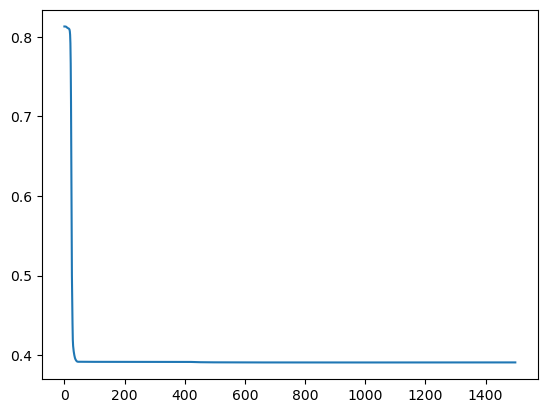

In [62]:

import torch.nn as nn

LEARNING_RATE = 0.001
EPOCHS = 1500

# Define the model
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(torch.tensor(x_train).float())
    loss = loss_fn(y_pred, torch.tensor(y_train).long())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss {loss.item()}")
        
model.eval()
y_pred = model(torch.tensor(x_train).float())
y_pred = torch.argmax(y_pred, dim=1)

# Evaluate training accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set is {accuracy}")

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

In [63]:
# Evaluate the model

model.eval()
y_pred = model(torch.tensor(x_test).float())
y_pred = torch.argmax(y_pred, dim=1)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on testing set is {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

# confusion_matrix(y_test, y_pred)
# display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=range(6))

# display.plot()


Accuracy on testing set is 0.9227941176470589
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1782
           1       0.93      0.92      0.92      1754

    accuracy                           0.92      3536
   macro avg       0.92      0.92      0.92      3536
weighted avg       0.92      0.92      0.92      3536



In [64]:
# Save the weights

weights_str = ""
biases_str = ""

for param in model.named_parameters():
    isBias = False
    if "0.weight" in param[0]:
        weights_str += ("custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {")
        isBias = False
    if "0.bias" in param[0]:
        biases_str += ("custom_float input_bias[HIDDEN_LAYER_NODES] = {")
        isBias = True
    if "2.weight" in param[0]:
        weights_str += ("custom_float output_weight[HIDDEN_LAYER_NODES * OUTPUT_NODES] = {")
        isBias = False
    if "2.bias" in param[0]:
        biases_str += ("custom_float output_bias[OUTPUT_NODES] = {")
        isBias = True
        
    weight = param[1].detach().numpy().flatten().tolist()
    for w in weight:
        if isBias:
            biases_str += str(w) + ","
        else:
            weights_str += str(w) + ","
            
    if isBias:
        biases_str += "};\n\n"
    else:
        weights_str += "};\n\n"
        
print(weights_str)
print(biases_str)

custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {9.198496991302818e-05,0.00032058547367341816,-0.0001472766016377136,0.00047258782433345914,0.000542530557140708,0.0011771244462579489,0.00033452766365371644,0.00042160466546192765,0.00012574288120958954,-2.2041460397304036e-05,0.00017840969667304307,0.0005242908955551684,0.00019113183952867985,0.00030220652115531266,-2.767415026028175e-05,0.00010847029625438154,7.164258568082005e-05,4.692150105256587e-05,6.1753649788443e-05,3.433228630456142e-05,7.992143946466967e-05,-0.00010660372208803892,-0.00012041121226502582,-0.00020802448852919042,3.773702701437287e-05,-0.00018568499945104122,7.964234100654721e-05,-9.957473230315372e-05,-0.00010346363706048578,-0.0002248161326861009,0.00013421924086287618,3.714491322170943e-05,0.0001214292278746143,-1.6916943650358007e-06,4.3175576138310134e-05,0.0004798263544216752,-3.483666660031304e-05,-0.0025182641111314297,0.0004137203504797071,-0.000506007403600961,-0.0009486993658356369,-0.001

In [68]:
# Generate test cases for HLS

random.seed(SEED)

TEST_CASES = 100

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)

test_cases = np.array(test_cases)
single_test_case = test_cases[12]

raw_output = model(torch.tensor(test_cases).float()).detach().numpy()
pred_output = np.argmax(raw_output, axis=1)
single_pred_output = pred_output[12]

test_cases_str = "float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {"
pred_output_str = "int test_output[TEST_CASES_NUMBER] = {"

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ","
for output in pred_output:
    pred_output_str += str(output) + ","

test_cases_str += "};\n"
pred_output_str += "};\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {-1.881,-0.4526,-0.3723,-2.8934,-2.7372,-1.5675,0.4702,0.8588,0.293,2.0092,1.5058,3.1261,-0.70617,0.13457999999999998,-0.026740000000000007,0.22146,-0.68953,0.69349,0.9696853057048972,0.3891747186033543,0.21922676022785176,1.6422417387217998,1.1598302453807627,1.750303955574574,1.1995689479975713,0.41178724846697234,0.22085153384117576,1.6571066531759506,1.3493175382392388,1.8826822134922294,0.07724738604796175,0.584,0.26160000000000005,0.9640000000000004,1.3879213088832028,2.414500000000001,9.5611,1.9879650558221378,1.0012741300140138,8.310525369386465,6.895300000000001,9.277740128291546,142.58940309999997,9.55455372,2.5087386599999997,140.21699758,116.27865811999999,204.18593998000003,-0.2325,-1.421,-3.3174,-1.1989,-0.8712,-4.0308,2.6707,1.0617,0.3773,2.2922,1.5559,5.003,1.1112499999999998,-0.23537,-1.4192500000000001,0.12972999999999996,0.021850000000000026,-0.20894,1.1861467946675066,0.8333006792868947,1.4077593851578472,1.16849274

In [66]:
# Generate single test case for pynq testing

TEST_CASES = 1

test_cases = []

for i in range(TEST_CASES):
    test_cases.append(single_test_case)

test_cases = np.array(test_cases)

pred_output = [ single_pred_output ]

test_cases_str = "test_input = ["
pred_output_str = "test_output = ["

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ", "
for output in pred_output:
    pred_output_str += str(output) + ", "

test_cases_str += "]\n"
pred_output_str += "]\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

test_input = [-0.479, -1.2179, -0.4232, -1.8137, -1.6443, -2.4633, -0.25, -0.6336, -0.0521, 1.7223, 1.2101, 1.5145, -0.37152, -0.9549599999999998, -0.27877, 0.01579999999999997, -0.06824000000000001, -0.12147999999999995, 0.07483608487888714, 0.17022435313432682, 0.10513370582263332, 1.2428805879890474, 0.9801326330655459, 1.323016568906074, 0.3789822555212843, 0.9700128514612577, 0.2979359142500279, 1.2429810119225475, 0.9825053058380907, 1.3285820381143199, 0.15664944178238732, 0.14990974565663218, 0.08891696617581848, 0.15799999999999992, 0.6823999999999999, 1.138002114427595, 3.7152000000000003, 9.5496, 2.7877, 8.085318979351786, 6.2702644806469285, 7.936206267958993, 14.111870000000001, 92.70797366, 8.337194300000002, 77.69912348, 51.61267835999998, 90.85490161999998, ]

test_output = [0, ]



In [67]:
import time

test_input = [[




        -0.479,




        -1.2179,




        -0.4232,




        -1.8137,




        -1.6443,




        -2.4633,




        -0.25,




        -0.6336,




        -0.0521,
        1.7223,
        1.2101,
        1.5145,




        -0.37152,




        -0.9549599999999998,




        -0.27877,
        0.01579999999999997,




        -0.06824000000000001,




        -0.12147999999999995,
        0.07483608487888714,
        0.17022435313432682,
        0.10513370582263332,
        1.2428805879890474,
        0.9801326330655459,
        1.323016568906074,
        0.3789822555212843,
        0.9700128514612577,
        0.2979359142500279,
        1.2429810119225475,
        0.9825053058380907,
        1.3285820381143199,
        0.15664944178238732,
        0.14990974565663218,
        0.08891696617581848,
        0.15799999999999992,
        0.6823999999999999,
        1.138002114427595,
        3.7152000000000003,
        9.5496,
        2.7877,
        8.085318979351786,
        6.2702644806469285,
        7.936206267958993,
        14.111870000000001,
        92.70797366,
        8.337194300000002,
        77.69912348,
        51.61267835999998,
        90.85490161999998
    ]]


start = time.time()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
end = time.time()

print("Time taken for 5 inferences is " + str((end - start)*1000) + " milliseconds")


print(output)

Time taken for 5 inferences is 0.9999275207519531 milliseconds
[[9.991561e-01 8.439083e-04]]
